# F9 Gene Analysis

In [1]:
import polars as pl
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
from scipy.stats import spearmanr, pearsonr
from adjustText import adjust_text
from matplotlib.colors import Normalize
from pycytominer.feature_select import feature_select
sys.path.append("../../../../utils")
from utils import *

import matplotlib.font_manager as fm

# Force TrueType font embedding (Type 42)
mpl.rcParams['svg.fonttype'] = 'none'  # keep text as text
# optional: make sure LaTeX text is OFF, or it will often become paths
mpl.rcParams['text.usetex'] = False

font_path = "../../../../utils/ARIAL.TTF"
fm.fontManager.addfont(font_path)

font_prop = fm.FontProperties(fname=font_path)
# Set font family to one of the accepted fonts
plt.rcParams.update({
    "font.family": font_prop.get_name(),
    "font.sans-serif": ["ARIAL"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

GENE = "F9"
BATCH_PROFILE_DIR = "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/batch_profiles"
SM_CLASS_RES_DIR = "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/classification_results/{batch_id}/"
FEAT = "GFP"
TOP_FEAT_NUM = 3

# # Original cell imaging profiles
BIO_REP_BATCHES_DICT = {
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

# f9_struc_df = pl.read_parquet("/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection/3_outputs/VarChAMP_Allele_Collection_1Perc_ClinVar_dbNSFP.parquet")
# f9_seq = f9_struc_df.filter(
#     pl.col("symbol")=="F9"
# )["seq_aa"].to_list()[0]
# print(f9_seq)

## 0. Loading F9 data

In [2]:
## Create the mapping expression with precise logic for a cleaner ClinVar Annotation USING Pillar team's strict Clinical Significance priority
clinvar_mapping_strict_pp = (
    # Pathogenic / Likely pathogenic
    pl.when(pl.col("clinvar_sig_2025")=="Pathogenic")
    .then(pl.lit("Pathogenic"))
    .when(pl.col("clinvar_sig_2025")=="Pathogenic/Likely pathogenic")
    .then(pl.lit("Likely pathogenic"))
    .when(pl.col("clinvar_sig_2025")=="Likely pathogenic")
    .then(pl.lit("Likely pathogenic"))

    # Benign / Likely benign
    .when(pl.col("clinvar_sig_2025")=="Benign")
    .then(pl.lit("Benign"))
    .when(pl.col("clinvar_sig_2025")=="Benign/Likely benign")
    .then(pl.lit("Likely benign"))
    .when(pl.col("clinvar_sig_2025")=="Likely benign")
    .then(pl.lit("Likely benign"))
    
    # Then check for Uncertain significance (VUS)
    .when(pl.col("clinvar_sig_2025")=="Uncertain significance")
    .then(pl.lit("VUS"))
    
    # Check for Conflicting
    .when(pl.col("clinvar_sig_2025")=="Conflicting classifications of pathogenicity")
    .then(pl.lit("Conflicting"))

    # Everything else goes to Others
    .otherwise(pl.lit("Others"))
)

clinvar_mapping_strict_pp_short_mapping = (
    # Pathogenic / Likely pathogenic
    pl.when(pl.col("clinvar_clnsig_clean_pp_strict").str.contains("Pathogenic"))
    .then(pl.lit("PLP"))
    # Benign / Likely benign
    .when(pl.col("clinvar_clnsig_clean_pp_strict").str.contains("Benign"))
    .then(pl.lit("BLB"))
    # Everything else goes to Others
    .otherwise(pl.lit("VUS"))
)

pillar_clinvar_single_aa_df = pl.read_csv(
    "../../../../1_allele_collection/3_outputs/pillar_snp_alleles.tsv",
    infer_schema_length=1000000, separator="\t"
).with_columns(
    clinvar_clnsig_clean_pp_strict=clinvar_mapping_strict_pp
).with_columns(
    clinvar_mapping_strict_pp_short=clinvar_mapping_strict_pp_short_mapping
)

def map_chr(num):
    if num == 23:
        return "X"
    elif num == 24:
        return "Y"
    elif num == 12920:
        return "MT"
    else:
        return str(num)

imaging_summary_clinvar = pl.read_csv("../../1_inputs/0_imaging_phenotype_summary_clinvar.tsv", separator="\t", infer_schema_length=100000).with_columns(
    pl.col("spdi").str.extract(r"NC_0*([0-9]+)", 1).cast(pl.Int32).alias("chr_num"),
    pl.col("spdi").str.split(":").list.get(1).str.strip_chars().cast(pl.Float64).alias("nuc_loc"),
    pl.col("spdi").str.split(":").list.get(2).str.strip_chars().alias("ref_allele"),
    pl.col("spdi").str.split(":").list.get(3).str.strip_chars().alias("alt_allele"),
).with_columns(
    pl.col("chr_num")
    .map_elements(map_chr, return_dtype=pl.String)
    .str.strip_chars()
    .alias("Chrom")
)
imaging_summary_clinvar_pillar_snp_match_df = imaging_summary_clinvar.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
)

imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df.with_columns(
    pl.col("clinvar_clnsig_clean_pp_strict")
        .cast(pl.Enum(clinvar_order_dict["original"]))
).sort(
    "clinvar_clnsig_clean_pp_strict"
).filter(
    pl.col("Gene")==GENE,
    # pl.col("Dataset")=="F9_Popp_2025_heavy_chain"
)
# .select(
#     "gene_allele", "GFP_corrected_mean_AUROC", "AUROC_Mean_GFP", "Altered_95th_perc_both_batches_GFP"
# ).sort("AUROC_Mean_GFP", descending=True)

# .select([
#     col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
#     if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
# ])

# with pl.Config(set_tbl_rows=100):
#     display(
#         class_metric_df_gfp_adj.sort("GFP_corrected_mean_AUROC", descending=True).filter(pl.col("gene_allele").str.contains("F9"))
#     )

imaging_summary_clinvar_pillar_snp_match_df_gene.unique("Dataset")["Dataset"].to_list()

['F9_Popp_2025_model',
 'F9_Popp_2025_carboxy_gla_motif',
 'F9_Popp_2025_light_chain',
 'F9_Popp_2025_strep_2',
 'F9_Popp_2025_carboxy_F9_specific',
 'F9_Popp_2025_heavy_chain']

## 1. F9 Overall Correlation

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


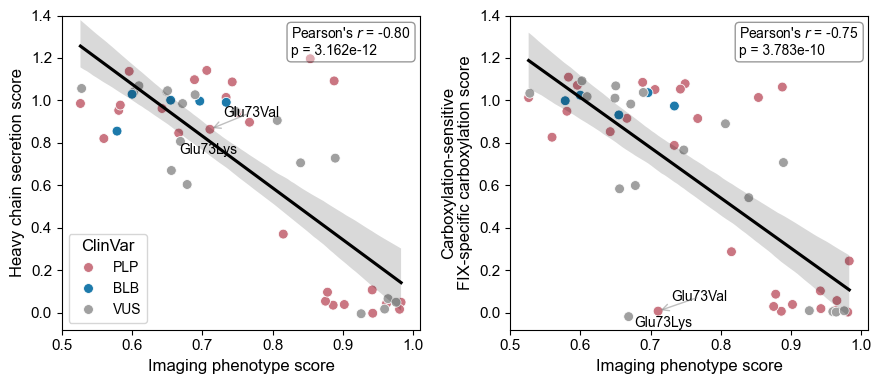

In [3]:
# imaging_summary_clinvar_pillar_snp_match_df_gene
fig, axes = plt.subplots(1, 2, figsize=(9, 4)) ##sharey=True, 
for j, study in enumerate(["F9_Popp_2025_heavy_chain", "F9_Popp_2025_carboxy_F9_specific"]):
    if "heavy" not in study and "specific" not in study:
        continue
    imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
        pl.col("Dataset")==study
    )
    imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.with_columns(
        pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
    )
    feat = "img_pheno_score"
    sns.scatterplot(
        data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.with_columns(
            pl.col("auth_reported_func_class").fill_null("Not reported").alias("auth_reported_func_class"),
            # pl.col(f"Altered_95th_perc_both_batches_{feat}").fill_null("Not reported").alias(f"Altered_95th_perc_both_batches_{feat}")
        ).to_pandas(),
        x=feat,
        y="auth_reported_score",
        ax=axes[j],
        hue="clinvar_mapping_strict_pp_short", ## clinvar_mapping_strict_pp_short, clinvar_clnsig_clean_pp_strict
        s=50,
    #    style=f"Altered_95th_perc_both_batches_{feat}",
        palette=palette_dict["clinvar_clnsig_clean_pp_strict"],
        hue_order=["PLP", "BLB", "VUS"]#clinvar_order_dict["original"]
    )
    sns.regplot(
        data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
        x=feat,
        y="auth_reported_score",
        ax=axes[j],
        scatter=False,
        color="black"
    )
    # Get pandas dataframe for easier indexing
    plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
    
    # Add point labels with adjustText
    texts = []
    for idx, row in plot_data.iterrows():
        if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[feat])) and "Glu73" in row["gene_variant"]:
            text = axes[j].annotate(
                row["gene_variant"].split('_')[-1],
                (row[feat], row["auth_reported_score"]),
                fontsize=10,
                color="black"#palette_dict["clinvar_clnsig_clean_pp_strict"][row["clinvar_clnsig_clean_pp_strict"]]
            )
            texts.append(text)

    adjust_text(
        texts,
        ax=axes[j],
        arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
        expand_text=(1.2, 1.4),
        expand_points=(1.2, 1.4),
        force_text=(0.5, 0.5),
        force_points=(0.5, 0.5),
        lim=200  # Increase from default (100)
    )

    # Calculate Spearman correlation
    mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[feat]))
    rho, p_val = pearsonr(
        plot_data["auth_reported_score"][mask], 
        plot_data[feat][mask]
    )

    # Add correlation text to plot
    axes[j].text(
        0.64, 0.965, 
        f'Pearson\'s $r$ = {rho:.2f}\np = {p_val:.3e}',
        fontsize=10,
        transform=axes[j].transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.4)
    )
    if j == 0:
        axes[j].set_ylabel("Heavy chain secretion score")
    else:
        axes[j].set_ylabel("Carboxylation-sensitive\nFIX-specific carboxylation score")

    axes[j].set_xlabel("Imaging phenotype score")
    # axes[j].set_title(study)
    axes[j].set_ylim(-.08, 1.4)
    axes[j].set_xlim(0.5, 1.01)
    # axes[j].grid(alpha=.2)
    axes[j].legend(fontsize=10, loc="lower left", title="ClinVar")
    if j != 0:
        axes[j].get_legend().remove()

plt.tight_layout()
plt.subplots_adjust(wspace=0.25) ## , hspace=0.22
plt.savefig("../../3_outputs/F9_MAVE_Img_Corr.svg", dpi=400, transparent=True, bbox_inches='tight')
plt.show()

## 2. Feature analysis

In [4]:
# batch_profile_filtcells_dir = "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/classification_results"
# batch_profile_dir = "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/batch_profiles"

# sc_profile_feat_orig_b1314 = pl.concat([
#     pl.read_parquet(f"{BATCH_PROFILE_DIR}/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier.parquet"),
#     pl.read_parquet(f"{BATCH_PROFILE_DIR}/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier.parquet")
# ], how="diagonal")
# sc_profile_feat_orig_b1314 = sc_profile_feat_orig_b1314.with_columns(
#     pl.concat_str(
#         [
#             "Metadata_Plate",
#             "Metadata_Well",
#             "Metadata_ImageNumber",
#             "Metadata_ObjectNumber",
#         ],
#         separator="_",
#     ).alias("Metadata_CellID")
# )

# sc_profile_feat_filtcells_b1314 = pl.concat([
#     pl.read_parquet(f"{BATCH_PROFILE_DIR}/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"),
#     pl.read_parquet(f"{BATCH_PROFILE_DIR}/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet")
# ], how="diagonal")
# sc_profile_feat_filtcells_b1314 = sc_profile_feat_filtcells_b1314.with_columns(
#     pl.concat_str(
#         [
#             "Metadata_Plate",
#             "Metadata_Well",
#             "Metadata_ImageNumber",
#             "Metadata_ObjectNumber",
#         ],
#         separator="_",
#     ).alias("Metadata_CellID")
# ).select([
#     "Metadata_CellID"
# ])

# sc_profile_feat_filtcells_gfp_corr_b1314 = pl.concat([
#     pl.read_parquet(f"{batch_profile_filtcells_dir}/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/gfp_adj_filtered_cells_profiles.parquet"),
#     pl.read_parquet(f"{batch_profile_filtcells_dir}/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/gfp_adj_filtered_cells_profiles.parquet")
# ], how="diagonal")
# sc_profile_feat_filtcells_gfp_corr_b1314 = sc_profile_feat_filtcells_gfp_corr_b1314.with_columns(
#     pl.concat_str(
#         [
#             "Metadata_Plate",
#             "Metadata_Well",
#             "Metadata_ImageNumber",
#             "Metadata_ObjectNumber",
#         ],
#         separator="_",
#     ).alias("Metadata_CellID")
# ).select([
#     "Metadata_CellID",
#     "Metadata_gene_allele",
#     "Metadata_Well",
#     "Metadata_Plate",
#     "Metadata_refvar_gfp_adj_classify"
# ])

# normalized_sc_profiles_b1314 = sc_profile_feat_filtcells_b1314.join(sc_profile_feat_orig_b1314, on="Metadata_CellID", how="inner")
# normalized_sc_profiles_b1314_filtered_gfp = sc_profile_feat_filtcells_gfp_corr_b1314.join(sc_profile_feat_orig_b1314, on="Metadata_CellID", how="inner")

# normalized_sc_profiles_b1314_filtered_gfp_f9 = normalized_sc_profiles_b1314_filtered_gfp.filter(
#     pl.col("Metadata_gene_allele").str.contains("F9")
# ).with_columns(
#     pl.col("Metadata_refvar_gfp_adj_classify").str.split("_").list.get(2).alias("F9_Variant")
# )
# normalized_sc_profiles_b1314_f9 = normalized_sc_profiles_b1314.filter(pl.col("Metadata_gene_allele").str.contains("F9"))

# normalized_sc_profiles_b1314_filtered_gfp_f9.write_parquet("../../3_outputs/2_results_summary/F9/ref_var_sc_profiles_mad_gfp_filtered.parquet", compression="zstd")
# normalized_sc_profiles_b1314_f9.write_parquet("../../3_outputs/2_results_summary/F9/ref_var_sc_profiles_mad_orig.parquet", compression="zstd")

# # normalized_sc_profiles_b1314_filtered_gfp_f9.write_parquet("/home/shenrunx/cell_represent/llm_guided_cp_feat_select/data/raw/large_files/f9/gfp_filtered_var_mad_sc_cp_profiles.parquet")
# # normalized_sc_profiles_b1314_f9.write_parquet("/home/shenrunx/cell_represent/llm_guided_cp_feat_select/data/raw/large_files/f9/orig_var_mad_sc_cp_features.parquet")

### 2.1 Top features for All F9 variants

In [5]:
batch_profile_filtcells_dir = "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/classification_results"
batch_profile_dir = "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/batch_profiles"

normalized_sc_profiles_b1314_f9 = pl.read_parquet("../../3_outputs/2_results_summary/F9/ref_var_sc_profiles_mad_orig.parquet")
normalized_sc_profiles_b1314_filtered_gfp_f9 = pl.read_parquet("../../3_outputs/2_results_summary/F9/ref_var_sc_profiles_mad_gfp_filtered.parquet")

In [6]:
feat_import_df_feat = pl.DataFrame()
feat_df = pl.DataFrame()

## select all feat with importance > 1e-3
importance_thres = 1e-3
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    bio_rep_batches = BIO_REP_BATCHES_DICT[bio_rep]
    ## ONLY grep the allele come from the bio-rep
    allele_batch_df = imaging_summary_clinvar.filter(pl.col("Metadata_Bio_Batch")==bio_rep)
    batch_allele_list = list(allele_batch_df["gene_variant"]) + list(allele_batch_df["symbol"].unique())
    for batch_id in bio_rep_batches:
        # Read the data
        feat_df_b = pl.scan_csv(f"{batch_profile_filtcells_dir}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/feat_importance_gfp_adj.csv")
        meta_cols = [c for c in feat_df_b.collect_schema().names() if c.startswith("Metadata_") or c.startswith("Group") or c == "Batch"]
        feat_cols = [c for c in feat_df_b.collect_schema().names() if c not in meta_cols and FEAT in c]
        feat_df_batch = feat_df_b.with_columns(
            [pl.col(c).cast(pl.Float64, strict=False).alias(c) for c in feat_cols]
        ).with_columns(
            pl.lit(batch_id).alias("Metadata_Batch"),
            pl.col("Group2").str.split('_').list.slice(-2).list.join("_").alias("Metadata_gene_allele")
       ).filter(
            (pl.col("Metadata_Feature_Type")==FEAT)&(~pl.col("Metadata_Control"))
            &(pl.col("Group1").is_in(batch_allele_list)|(pl.col("Metadata_gene_allele").is_in(batch_allele_list)))
        ).select(meta_cols + feat_cols + ["Metadata_Batch", "Metadata_gene_allele"])
        feat_import_df_feat = pl.concat([feat_import_df_feat, feat_df_batch.collect()], how="diagonal")


for j, allele in tqdm(imaging_summary_clinvar.filter(pl.col("Gene")==GENE).to_pandas().iterrows()):
    batch_list = list(feat_import_df_feat.filter(
        pl.col("Metadata_gene_allele")==allele["gene_variant"]
    ).unique("Metadata_Batch")["Metadata_Batch"])
    allele_df = pl.DataFrame()
    for i, batch in enumerate(batch_list):
        batch_df = feat_import_df_feat.filter(
            (pl.col("Metadata_Batch")==batch)&(pl.col("Metadata_gene_allele")==allele["gene_variant"])
        )
        feat_cols = [col for col in batch_df.columns if "Metadata" not in col and "Group" not in col]
        batch_df = batch_df.filter(
            ~pl.all_horizontal(pl.col(feat_cols).is_null())
        )
        non_null_gfp = [col for col in feat_cols if not batch_df[col].is_null().any()]
        batch_df_col = (
            batch_df.select(non_null_gfp).mean()
           .transpose(include_header=True)
           .filter(pl.col("column_0") > importance_thres)
           .sort("column_0", descending=True)
           # .head(top_num)#["column"]
           # .to_list()
        )
        if not allele_df.is_empty():
            allele_df = allele_df.join(
                batch_df_col.with_columns(
                    pl.col("column_0").alias(batch),
                    pl.col("column").alias("index"),
                ).select("index", batch),
                on="index",
                how="full",
                coalesce=True
            )
        else:
            allele_df = batch_df_col.with_columns(
                pl.col("column_0").alias(batch),
                pl.col("column").alias("index"),
            ).select("index", batch)
            
    if allele_df.is_empty():
        continue

    allele_df = allele_df.with_columns(
        pl.mean_horizontal(pl.col([col for col in allele_df.columns if "Batch" in col])).alias("feat_importance"),
        pl.col("index").alias("cp_feature")
    ).select(
        pl.col(["cp_feature", "feat_importance"])
    ).rename(
        {"feat_importance": allele["gene_variant"]}
    )

    if not feat_df.is_empty():
        feat_df = feat_df.join(
            allele_df,
            left_on="cp_feature",
            right_on="cp_feature",
            how="full",
            coalesce=True
        )
    else:
        feat_df = allele_df

50it [00:07,  7.07it/s]


In [7]:
sorted_unique_variants = imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_variant").sort(
    "img_pheno_score", descending=True
)["gene_variant"].to_list()
sorted_unique_variants = [var for var in sorted_unique_variants if var in feat_df.columns]
print(len(sorted_unique_variants))

## grep the top features to look at
# get_top_feats = feat_df[["cp_feature"]+[idx for idx in feat_df.columns if gene in idx]].with_columns(
#     pl.mean_horizontal(
#         pl.col(sorted_unique_variants)
#     ).alias('row_mean')
# ).sort(sorted_unique_variants, descending=True)["cp_feature"].to_list()[-10:][::-1]

## get the features with max_feat_importance > 0.015 in any GENE variant
# get_top_feats = feat_df.with_columns(
#     pl.mean_horizontal(
#         pl.col(sorted_unique_variants)
#     ).alias('row_mean')
# ).select(
#     ["cp_feature","row_mean"]+[idx for idx in feat_df.columns if gene in idx]
# ).filter(
#    pl.max_horizontal(sorted_unique_variants) > .015 #0.015
# ).sort("row_mean", descending=True)["cp_feature"].to_list()

your_score_array = imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_variant").sort(
    "img_pheno_score", descending=True
)["img_pheno_score"].to_numpy()

all_features = feat_df.select("cp_feature").unique().sort("cp_feature")
# Get top 10 for each variant with feature names
top_10_dfs = []
for col in sorted_unique_variants:
    top_10 = feat_df.filter(
        pl.col(col).is_in(pl.col(col).top_k(TOP_FEAT_NUM))
    ).select(["cp_feature", col])
    top_10_dfs.append(top_10)

# Start with all features and left join each variant's top 10
result_df = all_features
for i, col in enumerate(sorted_unique_variants):
    result_df = result_df.join(top_10_dfs[i], on="cp_feature", how="left")

subset_df = result_df.select(
    ["cp_feature"] + sorted_unique_variants
).filter(
    ~pl.all_horizontal(pl.all().exclude("cp_feature").is_null())
)
get_top3_feats_all_alleles = subset_df["cp_feature"].to_list()

# plt.clf()
# fig = plt.figure(figsize=(40, 12))
# gs = fig.add_gridspec(1, 2, width_ratios=[0.03, 1], wspace=.2)
# # Left side: score bar
# ax_left = fig.add_subplot(gs[:, 0])
# score_data = your_score_array.reshape(-1, 1)
# sns.heatmap(score_data, ax=ax_left, annot=True, cbar=False, cmap="viridis", 
#             yticklabels=False, xticklabels=['AUROC_GFP'], fmt='.3f', linewidth=.1)

# # Main heatmap
# ax_main = fig.add_subplot(gs[:, 1])
# sns.heatmap(
#   data=feat_df.to_pandas().set_index("cp_feature").loc[get_top3_feats_all_alleles,sorted_unique_variants].T,
#   ax=ax_main,
#   cmap="vlag",
#     center=0.01, vmin=0, vmax=0.09,
#   cbar_kws={"shrink": 0.5},
#     yticklabels=1,
#     xticklabels=1, linewidth=.1,
#     annot=True, fmt='.3f',annot_kws={"fontsize":7},
# )
# ax_main.set_ylabel('')
# ax_main.set_title("XGBClassifier_Feature_Importance")
# plt.show()

50


In [8]:
ref_var_cell_all_prof_df = normalized_sc_profiles_b1314_f9
norm_vars_feat_df, norm_var_sc_feat_df = pl.DataFrame(), pl.DataFrame()
sig_diff_feat = [feat for feat in ref_var_cell_all_prof_df.columns if "Metadata" not in feat and "GFP" in feat] #[feat for feat in get_top_feats if feat in ref_var_cell_all_prof_df.columns]

gene_mean = ref_var_cell_all_prof_df.filter(pl.col("Metadata_gene_allele")==GENE).select(sig_diff_feat).mean().to_numpy()[0].tolist()
gene_std = ref_var_cell_all_prof_df.filter(pl.col("Metadata_gene_allele")==GENE).select(sig_diff_feat).std().to_numpy()[0].tolist()

z_norm_var_sc_feat_df = ref_var_cell_all_prof_df.filter(
    (pl.col("Metadata_gene_allele").str.starts_with(f"{GENE}_"))
    &(pl.col("Metadata_gene_allele")!=GENE)
    &(pl.col("Metadata_gene_allele").is_in(imaging_summary_clinvar["gene_variant"].unique()))
).with_columns(
    [((pl.col(col) - pl.lit(gene_mean[i])) / pl.lit(gene_std[i])).alias(col)
    for i, col in enumerate(sig_diff_feat)]
)
norm_var_sc_feat_df = pl.concat([
    norm_var_sc_feat_df,
    z_norm_var_sc_feat_df
])
z_norm_var_feat_df = z_norm_var_sc_feat_df.group_by(
    "Metadata_gene_allele", "Metadata_Plate", "Metadata_Well" ## aggregate by well first
).agg(
    pl.col(col).median().alias(col)
    for col in sig_diff_feat
).group_by(
    "Metadata_gene_allele" ## aggregate by allele
).agg(
    pl.col(col).median().alias(col)
    for col in sig_diff_feat
)#.to_pandas().set_index("Metadata_gene_allele")[sig_diff_feat]

norm_vars_feat_df = pl.concat([norm_vars_feat_df, 
                                z_norm_var_feat_df],
                                how="diagonal")

In [9]:
norm_vars_feat_meta_df = pl.DataFrame(norm_vars_feat_df).join(
    imaging_summary_clinvar_pillar_snp_match_df_gene, #.unique("gene_allele"),
    left_on="Metadata_gene_allele",
    right_on="gene_variant"
).rename(
    dict(
        zip(
            [c for c in imaging_summary_clinvar_pillar_snp_match_df_gene.columns if c not in norm_vars_feat_df.columns and c != "gene_variant"],
            [f"Metadata_{c}" for c in imaging_summary_clinvar_pillar_snp_match_df_gene.columns if c not in norm_vars_feat_df.columns and c != "gene_variant"]
        )
    )
)
norm_vars_feat_meta_df.shape

(300, 1727)

### 2.2 Mislocalized F9 Variants

In [10]:
# norm_vars_feat_df.write_csv("norm_var_feat.csv")
# alleles = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
#     pl.col("auth_reported_score")<0.2
# ).sort("auth_reported_score")["gene_allele"].unique().to_list()

TOP_NUM_MISLOC_VAR = 5
misloc_alleles = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
    # pl.col("AUROC_Mean_GFP")>0.9393
    pl.col("Dataset")=="F9_Popp_2025_heavy_chain",
    pl.col("auth_reported_score")<0.2,
).sort("img_pheno_score", descending=True)["gene_variant"].unique().to_list()
print(', '.join([var.split('_')[1] for var in sorted(
    misloc_alleles, 
    key=lambda x: int(x.split('_')[1][3:-3])
)]))
print(len(misloc_alleles))


sorted_alleles_pos = ["F9"] + sorted(misloc_alleles, key=lambda x: int(x[6:-3]))
# Get top 10 for each variant with feature names
top_feat_misloc_alleles = []
for col in misloc_alleles:
    top_feats = feat_df.filter(
        pl.col(col).is_in(pl.col(col).top_k(TOP_NUM_MISLOC_VAR))
    ).select(["cp_feature", col])
    # print(top_feats.sort(col))
    top_feat_misloc_alleles.append(top_feats)
    
# Start with all features and left join each variant's top 10
result_df = feat_df.select("cp_feature").unique().sort("cp_feature")
for i, col in enumerate(misloc_alleles):
    result_df = result_df.join(top_feat_misloc_alleles[i], on="cp_feature", how="left")

misloc_var_top10_feat_df = result_df.select(
    ["cp_feature"] + misloc_alleles
).filter(
    ~pl.all_horizontal(pl.all().exclude("cp_feature").is_null())
)
get_top_n_feats_misloc_alleles_orig = misloc_var_top10_feat_df["cp_feature"].to_list()

# normalized_sc_profiles_b1314_f9.filter(
#     pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos)
# ).to_pandas()[get_top_n_feats_misloc_alleles_orig]

# ## feature selection
# misloc_var_sig_feat_sel_df = feature_select(
#     normalized_sc_profiles_b1314_f9.filter(
#         pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos)
#     ).to_pandas()[get_top_n_feats_misloc_alleles_orig], 
#     operation="variance_threshold"
# )
# misloc_var_sig_feat_sel_df = feature_select(
#     misloc_var_sig_feat_sel_df, operation="correlation_threshold", corr_threshold=0.8
# )
# get_top_n_feats_misloc_alleles = misloc_var_sig_feat_sel_df.columns
get_top_n_feats_misloc_alleles = get_top_n_feats_misloc_alleles_orig

## select feat importance > 0.01
# misloc_var_sig_feat_df = feat_df.filter(
#     # pl.col(col).is_in(pl.col(col).top_k(10))
#     pl.max_horizontal(misloc_alleles) > .01
# )
# get_sig_feats_misloc_alleles = misloc_var_sig_feat_df["cp_feature"].to_list()

Cys28Arg, Tyr161Cys, Asn166Tyr, Cys170Tyr, Arg294Gln, Ile316Thr, Pro333Leu, Cys335Tyr, Cys335Trp, Val374Phe, Phe395Ile, Cys396Ser, Ala397Pro, Trp453Arg
14


/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


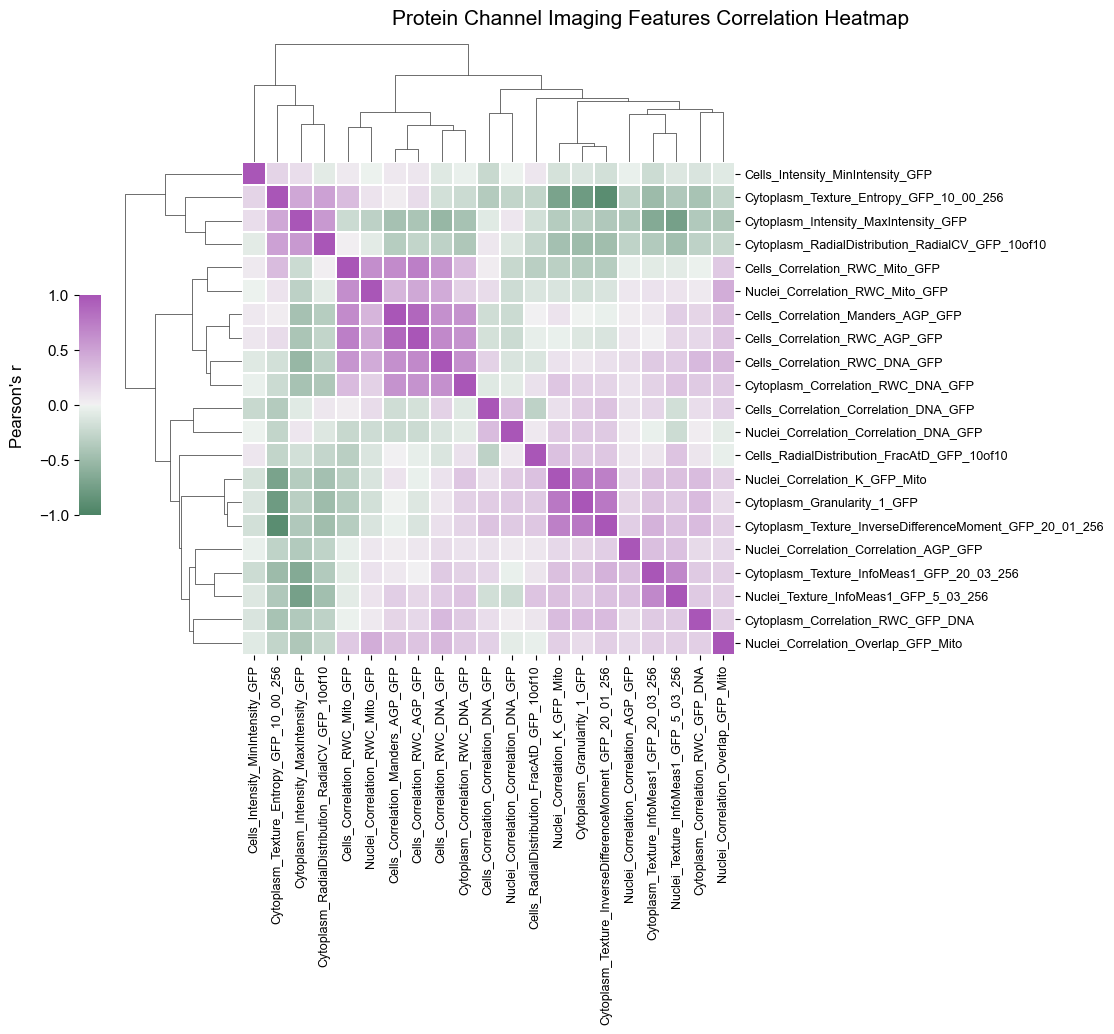

<ipython-input-11-eb0e3e922a83>:109: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


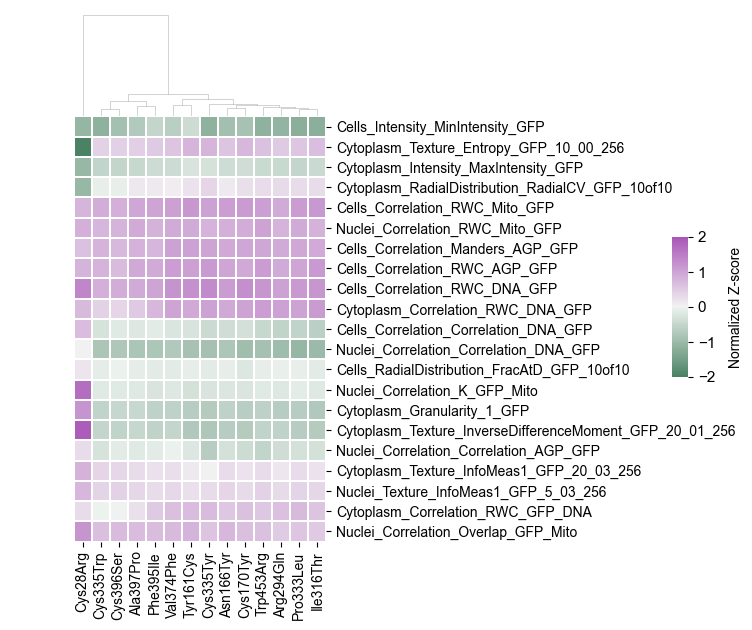

In [11]:
# sns.regplot(
#     data=normalized_sc_profiles_b1314_f9.filter(
#         pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos)
#     ).to_pandas().sort_values(by=["Metadata_gene_allele"], ascending=True),
#     x="Nuclei_Correlation_K_GFP_Mito",
#     y="Nuclei_Texture_DifferenceVariance_GFP_5_00_256"
# )
# plt.show()
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)


corr_df = normalized_sc_profiles_b1314_f9.filter(
    pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos)
).to_pandas()[get_top_n_feats_misloc_alleles].corr(method="pearson") ## get_sig_feats_misloc_alleles, get_top_n_feats_misloc_alleles
g = sns.clustermap(
    corr_df,
    cmap=cmap, center=0,
    vmin=-1, vmax=1,
    cbar_pos=(-.02, 0.55, 0.02, 0.2),
    yticklabels=1, xticklabels=1,
    square=True,
    figsize=(11,11),
    # annot=True, fmt=".2f",
    linewidth=.05, 
    # ax=ax
)
g.fig.suptitle("Protein Channel Imaging Features Correlation Heatmap", fontsize=15, y=1.01)
g.cax.yaxis.set_label_position('left')
g.cax.yaxis.set_ticks_position('left')
g.cax.set_ylabel(r"Pearson's r", labelpad=10) ##pearman's $\rho$
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
plt.show(g)

col_order = list(corr_df.columns[g.dendrogram_col.reordered_ind])

norm_vars_feat_meta_df_unique = norm_vars_feat_meta_df.sort(
    "Metadata_img_pheno_score", descending=True
).unique("Metadata_gene_allele")
# Combine both color arrays as separate columns
df = norm_vars_feat_meta_df_unique.to_pandas().set_index(
    "Metadata_gene_allele"
).loc[:,[c for c in norm_vars_feat_meta_df_unique.columns if "Metadata" not in c]] ## [c for c in get_top_feats if c in norm_vars_feat_meta_df.columns]
filtered_df = df #df.loc[:,  (df.std() > 0.15)] ##(df.abs().mean() > 0.1) &

# Create row colors - AUROC scores
auroc_colors_series = pd.Series(
    norm_vars_feat_meta_df_unique["Metadata_img_pheno_score"].to_numpy(), 
    index=filtered_df.index, name='AUROC_GFP'
)

norm = Normalize(vmin=auroc_colors_series.min(), vmax=auroc_colors_series.max())
auroc_colors = cmap(norm(auroc_colors_series.values))

row_colors_df = pd.DataFrame(index=filtered_df.index)
row_colors_df['AUROC_GFP'] = list(auroc_colors)

col_colors_df = pd.DataFrame(index=filtered_df.columns)
col_colors_df['Annotation'] = ["forestgreen" if "Intensity" in f else "skyblue" for f in filtered_df.columns]
col_colors_df = col_colors_df.sort_values("Annotation")

# Create clustermap with cluster-based ordering
g_final = sns.clustermap(
   data=filtered_df.loc[misloc_alleles, col_order].T, ## get_sig_feats_misloc_alleles. get_top_n_feats_misloc_alleles, get_top3_feats_all_alleles
   cmap=cmap, center=0,
   vmin=-2, vmax=2,
#    row_colors=row_colors_df,
#    col_colors=col_colors_df,
   row_cluster=False,
   col_cluster=True,
   cbar_pos=(.85, 0.45, 0.02, 0.2),
   yticklabels=1, xticklabels=1,
   figsize=(8, 7),
   tree_kws={'alpha': .3},  # Make dendrogram invisible
   linewidth=.1,
   colors_ratio=0.05  # Controls row_colors width,
)

# Set tick label sizes
# g.ax_heatmap.tick_params(axis='y', labelsize=10)  # y-axis labels
# g.ax_heatmap.tick_params(axis='x', rotation=45)  # x-axis labels
# g_final.fig.suptitle("Protein Channel Imaging Features Z-score Heatmap", fontsize=15, y=1.01)
# Add label to main heatmap colorbar
g_final.cax.set_ylabel('Normalized Z-score', labelpad=10, fontsize=10) ##  VAR vs REF
g_final.ax_heatmap.set_xlabel('')
g_final.ax_heatmap.set_ylabel('')
g_final.ax_heatmap.set_xticklabels([x.get_text().split('_')[1] for x in g_final.ax_heatmap.get_xticklabels()], fontsize=10) ##, rotation=60, ha='right'
g_final.ax_heatmap.set_yticklabels(g_final.ax_heatmap.get_yticklabels(), fontsize=10)

# g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=9) # Adjust fontsize as needed
# # Get current ytick labels
# ytick_labels = g.ax_heatmap.get_yticklabels()
# subset_variants = high_score_mask[high_score_mask].index
# # Color the labels
# for label in ytick_labels:
#    variant_name = label.get_text()
#    if variant_name in subset_variants:
#          label.set_color('red')  # Color for subset members
#    else:
#          label.set_color('black')  # Default color for others

# Add colorbar for AUROC scores
# auroc_cbar_ax = g.fig.add_axes([.1, 0.62, 0.02, 0.2])
# auroc_cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=auroc_cbar_ax)
# auroc_cbar.set_label('AUROC_GFP', rotation=90, labelpad=5)
# auroc_cbar.ax.yaxis.set_label_position('left')
# auroc_cbar.ax.yaxis.tick_left()

plt.tight_layout()
g_final.savefig("../../3_outputs/F9_variant_heatmap.svg", dpi=400, transparent=True, bbox_inches='tight')
plt.show(g_final)

new_allele_order = ["F9"] + list(filtered_df.loc[misloc_alleles, col_order].index[g_final.dendrogram_col.reordered_ind])

In [12]:
raw_f9_profiles = pl.concat([
    pl.scan_parquet(f"{BATCH_PROFILE_DIR}/2025_01_27_Batch_13/profiles.parquet").filter(
        pl.col("Metadata_symbol").str.contains("F9")
    ).with_columns(
        (pl.col("Nuclei_Intensity_IntegratedIntensity_GFP") / pl.col("Cytoplasm_Intensity_IntegratedIntensity_GFP")).alias("Nuc2Cyto_Ratio_Integrated"),
        (pl.col("Nuclei_Intensity_MeanIntensity_GFP") / pl.col("Cytoplasm_Intensity_MeanIntensity_GFP")).alias("Nuc2Cyto_Ratio_Mean")
    ).select(
        pl.col([
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
            "Nuc2Cyto_Ratio_Integrated",
            "Nuc2Cyto_Ratio_Mean"
        ])
    ).collect(),
    pl.scan_parquet(f"{BATCH_PROFILE_DIR}/2025_01_28_Batch_14/profiles.parquet").filter(
        pl.col("Metadata_symbol").str.contains("F9")
    ).with_columns(
        (pl.col("Nuclei_Intensity_IntegratedIntensity_GFP") / pl.col("Cytoplasm_Intensity_IntegratedIntensity_GFP")).alias("Nuc2Cyto_Ratio_Integrated"),
        (pl.col("Nuclei_Intensity_MeanIntensity_GFP") / pl.col("Cytoplasm_Intensity_MeanIntensity_GFP")).alias("Nuc2Cyto_Ratio_Mean")
    ).select(
        pl.col([
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
            "Nuc2Cyto_Ratio_Integrated",
            "Nuc2Cyto_Ratio_Mean"
        ])
    ).collect()
], how="diagonal")

raw_f9_profiles = raw_f9_profiles.with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber"
        ],
        separator="_",
    ).alias("Metadata_CellID")
)

In [13]:
value_column, group_column = "Nuc2Cyto_Ratio_Mean", "Metadata_gene_allele"
df_temp = normalized_sc_profiles_b1314_f9.filter(
    pl.col("Metadata_gene_allele").is_in(new_allele_order)
).join(
    raw_f9_profiles.select(pl.col(["Metadata_CellID","Nuc2Cyto_Ratio_Integrated","Nuc2Cyto_Ratio_Mean"])),
    on="Metadata_CellID",
    how="inner"
).with_columns(
    # Calculate Q1 for the group
    q1=pl.col(value_column).quantile(0.25).over(group_column),
    # Calculate Q3 for the group
    q3=pl.col(value_column).quantile(0.75).over(group_column)
).with_columns(
    # Calculate the IQR
    iqr=(pl.col('q3') - pl.col('q1')),
).with_columns(
    # Calculate the Lower Bound (Q1 - 1.5 * IQR)
    lower_bound=(pl.col('q1') - 1.5 * pl.col('iqr')),
    # Calculate the Upper Bound (Q3 + 1.5 * IQR)
    upper_bound=(pl.col('q3') + 1.5 * pl.col('iqr'))
)
# 2.2 Filter the DataFrame using the group-specific bounds
df_temp = df_temp.filter(
    (pl.col(value_column) >= pl.col('lower_bound')) &
    (pl.col(value_column) <= pl.col('upper_bound'))
)

# .filter(
#     (pl.col("Nuc2Cyto_Ratio_Mean").quantile(0.25).over(pl.lit(1)) - 
#      1.5 * (pl.col("Nuc2Cyto_Ratio_Mean").quantile(0.75).over(pl.lit(1)) - 
#             pl.col("Nuc2Cyto_Ratio_Mean").quantile(0.25).over(pl.lit(1)))) 
#     .le(pl.col("Nuc2Cyto_Ratio_Mean")),
#     (pl.col("Nuc2Cyto_Ratio_Mean").quantile(0.75).over(pl.lit(1)) + 
#      1.5 * (pl.col("Nuc2Cyto_Ratio_Mean").quantile(0.75).over(pl.lit(1)) - 
#             pl.col("Nuc2Cyto_Ratio_Mean").quantile(0.25).over(pl.lit(1)))) 
#     .ge(pl.col("Nuc2Cyto_Ratio_Mean"))
# )

# features_to_plot = [
#     "Nuc2Cyto_Ratio_Integrated", "Nuc2Cyto_Ratio_Mean"
# ]
# fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(8, len(features_to_plot)*2.4), sharex=True)
# color_palette = {
#     key: ("tomato" if key != "F9" else "skyblue")
#     for key in new_allele_order
# }
# for i, feat in enumerate(features_to_plot):
#     sns.violinplot(
#         data=df_temp.to_pandas(),
#         x="Metadata_gene_allele",
#         y=feat,
#         # showfliers=False,
#         ax=axes[i],
#         hue="Metadata_gene_allele",
#         palette=color_palette,
#         order=new_allele_order,
#         # showfliers=True
#         cut=0
#     )
#     axes[i].set_ylabel(f"{feat.split('_')[0]}\n{'_'.join(feat.split('_')[1:3])}\n{'_'.join(feat.split('_')[3:])}\n(A.U.)", fontsize=8)
#     ref_median = df_temp[feat].median()
#     axes[i].axhline(ref_median, color='darkblue', linestyle='--', linewidth=1.5)
#     axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=8)

# axes[-1].set_xlabel("F9 Variants", fontsize=8)
# axes[-1].set_xticklabels(axes[-1].get_xticklabels(), fontsize=8, rotation=25, ha='right')

# plt.subplots_adjust(hspace=0.12)
# plt.show()

<ipython-input-14-0c51b6a626f1>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=8)
<ipython-input-14-0c51b6a626f1>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=8)
<ipython-input-14-0c51b6a626f1>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[-1].set_xticklabels(axes[-1].get_xticklabels(), fontsize=8, rotation=25, ha='right')


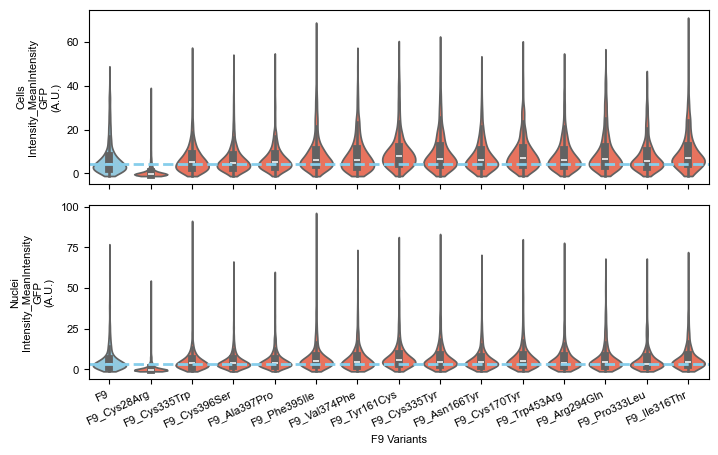

In [14]:
features_to_plot = [
    # "Cells_Intensity_IntegratedIntensity_GFP",
    "Cells_Intensity_MeanIntensity_GFP",
    # "Cells_Intensity_MaxIntensityEdge_GFP",
    # "Cells_Intensity_MinIntensityEdge_GFP",
    # "Cells_Intensity_MeanIntensityEdge_GFP",
    "Nuclei_Intensity_MeanIntensity_GFP"
]

fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(8, len(features_to_plot)*2.4), sharex=True)
color_palette = {
    key: ("tomato" if key != "F9" else "skyblue")
    for key in new_allele_order
}
for i, feat in enumerate(features_to_plot):
    sns.violinplot(
        data=normalized_sc_profiles_b1314_f9.filter(
            pl.col("Metadata_gene_allele").is_in(new_allele_order)
        ).to_pandas().sort_values(by=["Metadata_gene_allele"], ascending=True),
        x="Metadata_gene_allele",
        y=feat,
        # showfliers=False,
        ax=axes[i],
        hue="Metadata_gene_allele",
        palette=color_palette,
        order=new_allele_order,
        cut=0
    )
    axes[i].set_ylabel(f"{feat.split('_')[0]}\n{'_'.join(feat.split('_')[1:3])}\n{'_'.join(feat.split('_')[3:])}\n(A.U.)", fontsize=8)
    ref_median = normalized_sc_profiles_b1314_f9.filter(
        pl.col("Metadata_gene_allele")=="F9"
    )[feat].median()
    axes[i].axhline(ref_median, color='skyblue', linestyle='--', linewidth=2)
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=8)

axes[-1].set_xlabel("F9 Variants", fontsize=8)
axes[-1].set_xticklabels(axes[-1].get_xticklabels(), fontsize=8, rotation=25, ha='right')

plt.subplots_adjust(hspace=0.12)
plt.show()

<ipython-input-15-a3b2466c9a34>:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=10)
<ipython-input-15-a3b2466c9a34>:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=10)
<ipython-input-15-a3b2466c9a34>:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=10)
<ipython-input-15-a3b2466c9a34>:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=10)
<ipython-input-15-a3b2466c9a34>:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[-1].set_xticklabels([x.get_text().split('_')[-1] for x in axes[-1].get_xticklabels()], fontsize=10, rotation=25, ha='right')


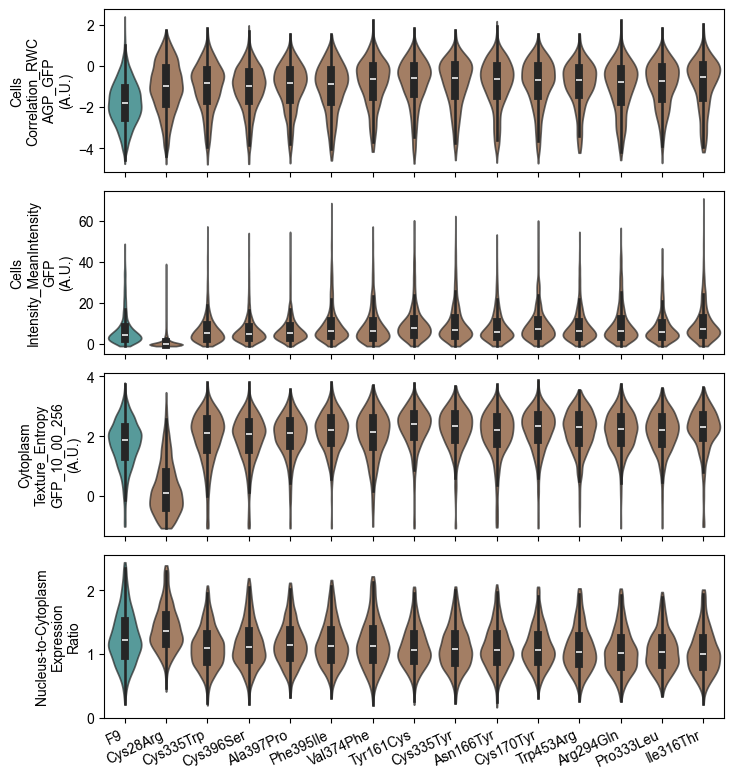

In [15]:
features_to_plot = [
    # "Nuclei_RadialDistribution_FracAtD_GFP_6of10",
    "Cells_Correlation_RWC_AGP_GFP",
    "Cells_Intensity_MeanIntensity_GFP",
    # "Cells_Intensity_MinIntensity_GFP", 
    "Cytoplasm_Texture_Entropy_GFP_10_00_256",
    "Nuc2Cyto_Ratio_Mean"
    # "Nuclei_Correlation_K_GFP_Mito", 
    # "Cytoplasm_Granularity_1_GFP",
    # "Nuclei_Correlation_K_GFP_AGP", 
    # "Nuclei_Correlation_Correlation_AGP_GFP", 
    # "Cells_Correlation_Correlation_DNA_GFP", 
] ##, Cytoplasm_Correlation_RWC_DNA_GFP, "Nuclei_Texture_DifferenceVariance_GFP_5_00_256"
# features_to_plot = misloc_var_top10_feat_df.sort("F9_Cys28Arg", descending=True, nulls_last=True).head(5)["cp_feature"].to_list()

# fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(8, len(features_to_plot)*2.5), sharex=True)
# color_palette = {
#     key: ("tomato" if key != "F9" else "skyblue")
#     for key in sorted_alleles_pos
# }
# for i, feat in enumerate(features_to_plot):
#     sns.violinplot(
#         data=z_norm_var_sc_feat_df.filter(
#             pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos)
#         ).to_pandas().sort_values(by=["Metadata_gene_allele"], ascending=True),
#         x="Metadata_gene_allele",
#         y=feat,
#         # showfliers=False,
#         ax=axes[i],
#         color="tomato",
#         # hue="Metadata_gene_allele",
#         order=sorted_alleles_pos[1:],
#         cut=0
#     )
#     axes[i].set_ylabel(f"{feat.split('_')[0]}\n{'_'.join(feat.split('_')[1:3])}\n{'_'.join(feat.split('_')[3:])}\n(Z-score)")
#     axes[i].axhline(0, color='skyblue', linestyle='--', linewidth=1)

# axes[-1].set_xlabel("F9 Variants")
# axes[-1].set_xticklabels(axes[-1].get_xticklabels(), rotation=25, ha='right')
# plt.subplots_adjust(hspace=0.1)
# plt.show()

fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(8, len(features_to_plot)*2.3), sharex=True)
color_palette = {
    key: ("#8B4513" if key != "F9" else "#008080") ## #008080 / #8B4513 | #FF7F50 / 5F7A8A
    for key in new_allele_order
}

for i, feat in enumerate(features_to_plot):
    if feat == "Nuc2Cyto_Ratio_Mean":
        df_plot = df_temp
    else:
        df_plot = normalized_sc_profiles_b1314_f9.filter(
            pl.col("Metadata_gene_allele").is_in(new_allele_order)
        )

    sns.violinplot(
        data=df_plot.to_pandas(),
        x="Metadata_gene_allele",
        y=feat,
        # showfliers=False,
        ax=axes[i],
        hue="Metadata_gene_allele",
        palette=color_palette,
        alpha=.7,
        order=new_allele_order,
        cut=0
    )
    # Make fill transparent, keep edge colored
    # for violin in axes[i].collections:
    #     violin.set_facecolor('none')  # Transparent fill
    #     # Edge color already set by palette
        
    if ("Ratio" not in feat):
        axes[i].set_ylabel(f"{feat.split('_')[0]}\n{'_'.join(feat.split('_')[1:3])}\n{'_'.join(feat.split('_')[3:])}\n(A.U.)", fontsize=10)
    else:
        axes[i].set_ylabel(f"Nucleus-to-Cytoplasm\nExpression\nRatio", fontsize=10)
        
    ref_median = df_plot.filter(
        pl.col("Metadata_gene_allele")=="F9"
    )[feat].median()
    # axes[i].axhline(ref_median, color='skyblue', linestyle='--', linewidth=2)
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=10)

axes[-1].set_xlabel("", fontsize=8)
axes[-1].set_ylim(0, None)
axes[-1].set_xticklabels([x.get_text().split('_')[-1] for x in axes[-1].get_xticklabels()], fontsize=10, rotation=25, ha='right')

plt.subplots_adjust(hspace=0.12)
plt.savefig("../../3_outputs/F9_sc_gfp_feat_dist.svg", dpi=400, transparent=True, bbox_inches='tight')
plt.show()

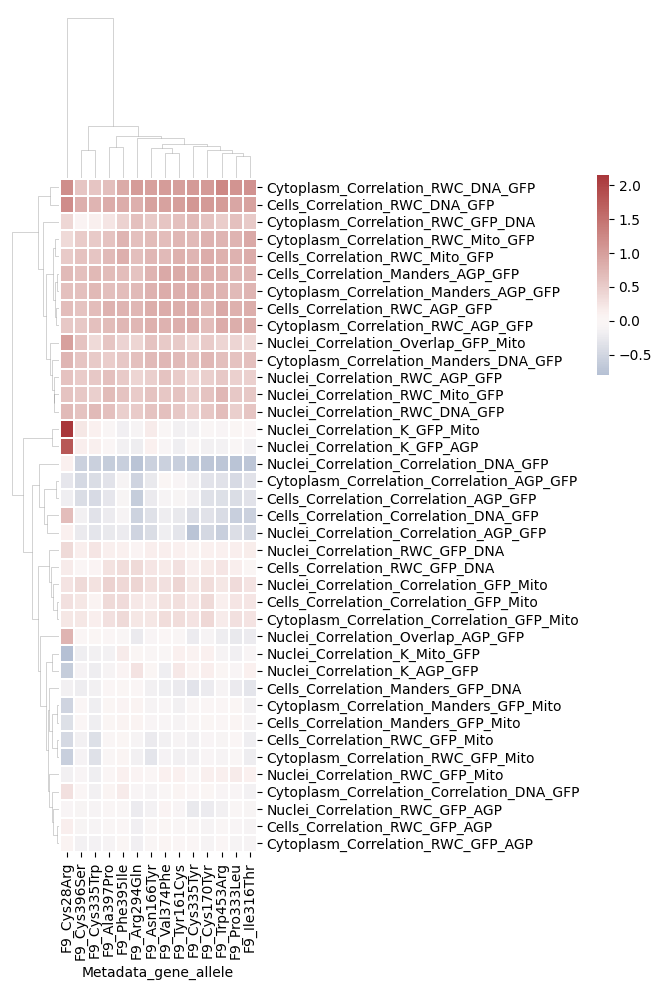

In [ ]:
gfp_coloc_feats = [c for c in normalized_sc_profiles_b1314_f9.columns if "GFP" in c and ("Mito" in c or "AGP" in c or "DNA" in c)]
sns.clustermap(
   data=filtered_df.loc[misloc_alleles, gfp_coloc_feats].T,
   cmap="vlag", center=0,
#    row_colors=row_colors_df,
#    col_colors=col_colors_df,
#    row_cluster=True,
   col_cluster=True,
   cbar_pos=(1.003, 0.62, 0.02, 0.2),
   yticklabels=1, xticklabels=1,
   figsize=(6,10),
   tree_kws={'alpha': .3},  # Make dendrogram invisible
    linewidth=.1,
    colors_ratio=0.05  # Controls row_colors width,
)
plt.show()

In [ ]:
# normalized_sc_profiles_b1314_filtered_gfp.filter(
#     pl.col("Metadata_gene_allele").is_in(alleles)
# ).to_pandas()[["Metadata_gene_allele","Cells_Intensity_MinIntensity_GFP"]]

In [ ]:
normalized_sc_profiles_b1314_filtered_gfp_f9.filter(
    pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos)
).unique("Metadata_gene_allele")

Metadata_CellID,Metadata_gene_allele,Metadata_Well,Metadata_Plate,Metadata_refvar_gfp_adj_classify,Metadata_plate_map_name,Metadata_well_position,Metadata_symbol,Metadata_gene_allele_right,Metadata_imaging_well,Metadata_imaging_plate_R1,Metadata_imaging_plate_R2,Metadata_node_type,Metadata_orf_id_wt,Metadata_ccsb_mutation_id,Metadata_nt_change_cdna,Metadata_aa_change,Metadata_allele_set,Metadata_imaging_plate,Metadata_batch1,Metadata_batch2,Metadata_clone_ID,Metadata_hgmd_ID,Metadata_clinvar_allele_ID,Metadata_clinvar_clinical_significance,Metadata_vector,Metadata_notes,Metadata_plate,Metadata_quad,Metadata_c96,Metadata_r96,Metadata_r384,Metadata_c384,Metadata_r384_letter,Metadata_Well_right,Metadata_TableNumber,Metadata_ImageNumber,…,Nuclei_Texture_SumAverage_DNA_5_01_256,Nuclei_RadialDistribution_FracAtD_DNA_6of10,Nuclei_Texture_DifferenceVariance_GFP_5_01_256,Cells_Texture_SumAverage_DNA_20_02_256,Cytoplasm_Location_MaxIntensity_X_AGP,Cells_RadialDistribution_MeanFrac_mito_tubeness_11of20,Cells_Texture_SumAverage_Mito_5_01_256,Cytoplasm_Texture_SumAverage_Mito_20_02_256,Cells_Texture_DifferenceVariance_GFP_20_01_256,Nuclei_Texture_Contrast_AGP_20_00_256,Cells_RadialDistribution_FracAtD_mito_tubeness_13of20,Nuclei_Texture_SumAverage_GFP_5_01_256,Cytoplasm_Granularity_10_AGP,Cytoplasm_Texture_InfoMeas1_Mito_20_02_256,Cytoplasm_Granularity_1_AGP,Nuclei_Texture_SumVariance_DNA_5_03_256,Cytoplasm_Correlation_K_AGP_DNA,Cells_Granularity_11_GFP,Cytoplasm_Texture_InfoMeas1_DNA_20_03_256,Cytoplasm_Granularity_14_AGP,Cytoplasm_Texture_SumVariance_DNA_20_02_256,Cytoplasm_Texture_Contrast_DNA_20_00_256,Cells_Granularity_14_AGP,Nuclei_Texture_Variance_DNA_10_00_256,Cytoplasm_Correlation_Overlap_AGP_DNA,Nuclei_Granularity_13_AGP,Nuclei_Texture_Variance_DNA_10_02_256,Cells_Texture_Contrast_DNA_10_02_256,Cytoplasm_Texture_SumVariance_DNA_20_00_256,Cytoplasm_Texture_Variance_DNA_20_00_256,Cytoplasm_Texture_InfoMeas1_DNA_20_01_256,Cytoplasm_Correlation_K_DNA_AGP,Cytoplasm_Texture_Contrast_DNA_20_02_256,Cells_Texture_Contrast_DNA_10_00_256,Cytoplasm_Texture_Variance_DNA_20_02_256,Nuclei_Texture_SumVariance_DNA_5_01_256,F9_Variant
str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str
"""2025_01_27_B13A7A8P1_T1_C20_60…","""F9_Arg294Gln""","""C20""","""2025_01_27_B13A7A8P1_T1""","""F9_F9_Arg294Gln_G06-C20_q0.25-…","""B13A7A8P1_R1""","""C20""","""F9""","""F9_Arg294Gln""","""C20""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",52861.0,"""CCSBVarC004382""","""881G>A""","""Arg294Gln""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,2,10,2,3,20,"""C""","""C20""",1632832079,608,…,1.506852,1.006336,-0.911872,0.280316,-0.324324,0.650598,-0.603182,-0.25438,-0.894097,2.350112,-0.656657,2.810868,0.978089,-1.839099,-0.530057,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Arg294Gln"""
"""2025_01_27_B13A7A8P1_T1_M18_27…","""F9_Cys28Arg""","""M18""","""2025_01_27_B13A7A8P1_T1""","""F9_F9_Cys28Arg_G06-M18_q0.15-0…","""B13A7A8P1_R1""","""M18""","""F9""","""F9_Cys28Arg""","""M18""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",52861.0,"""CCSBVarC004373""","""82T>C""","""Cys28Arg""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,2,9,7,13,18,"""M""","""M18""",3711877194,2748,…,2.086894,0.18073,-0.724423,4.746613,-1.447876,1.017205,-0.19802,-0.462792,-0.719502,6.46876,-0.577884,0.967682,0.265485,-1.861704,-2.041123,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cys28Arg"""
"""2025_01_27_B13A7A8P1_T1_I06_17…","""F9_Cys335Tyr""","""I06""","""2025_01_27_B13A7A8P1_T1""","""F9_F9_Cys335Tyr_G06-I06_q0.25-…","""B13A7A8P1_R1""","""I06""","""F9""","""F9_Cys335Tyr""","""I06""","""B13A7A8P1_R1""","""

<Figure size 640x480 with 0 Axes>

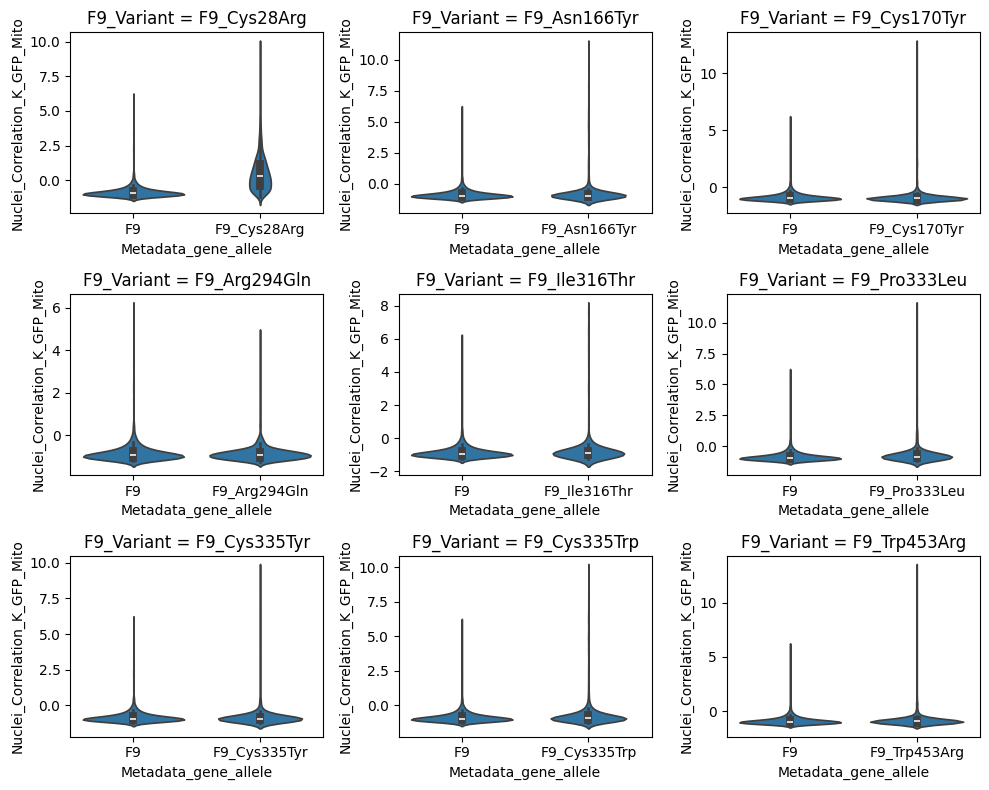

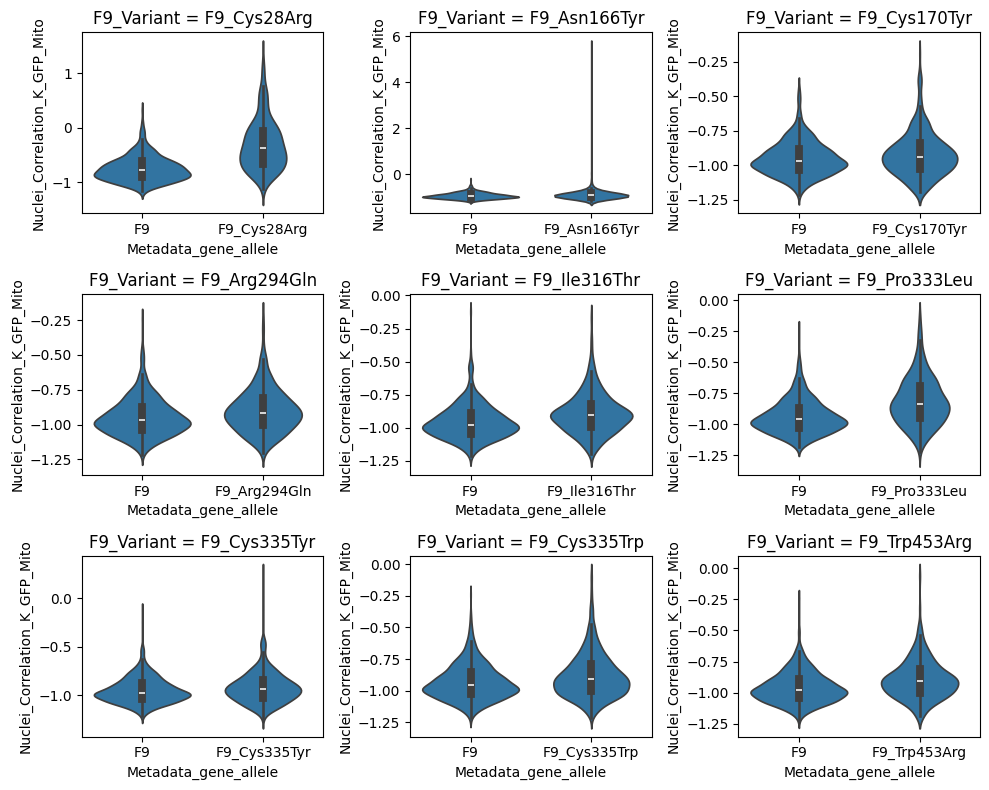

In [ ]:
plt.clf()

fig, axes = plt.subplots(3, 3, figsize=(10, 8))
axes = axes.flatten()
df_pandas = normalized_sc_profiles_b1314_f9.filter(
    pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos),
).to_pandas()
for idx, variant in enumerate(sorted_alleles_pos[1:]):
    group = df_pandas[(df_pandas["Metadata_gene_allele"]==variant)|(df_pandas["Metadata_gene_allele"]=="F9")]
    order = sorted(group["Metadata_gene_allele"].unique())
    sns.violinplot(data=group, x="Metadata_gene_allele", y="Nuclei_Correlation_K_GFP_Mito", 
                   order=order, ax=axes[idx])
    axes[idx].set_title(f"F9_Variant = {variant}")
    axes[idx].set_xlabel("Metadata_gene_allele")
    axes[idx].set_ylabel("Nuclei_Correlation_K_GFP_Mito")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(10,8))
axes = axes.flatten()
df_pandas = normalized_sc_profiles_b1314_filtered_gfp_f9.filter( ##normalized_sc_profiles_b1314_filtered_gfp_f9
    pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos),
    pl.col("F9_Variant").is_in([x.split("_")[-1] for x in sorted_alleles_pos]),
).to_pandas()
for idx, variant in enumerate(sorted_alleles_pos[1:]):
    group = df_pandas[(df_pandas["F9_Variant"]==variant.split("_")[-1])]
    order = sorted(group["Metadata_gene_allele"].unique())
    sns.violinplot(data=group, x="Metadata_gene_allele", y="Nuclei_Correlation_K_GFP_Mito", 
                   order=order, ax=axes[idx])
    axes[idx].set_title(f"F9_Variant = {variant}")
    axes[idx].set_xlabel("Metadata_gene_allele")
    axes[idx].set_ylabel("Nuclei_Correlation_K_GFP_Mito")
plt.tight_layout()
plt.show()

In [ ]:
gfp_feat_corr = normalized_sc_profiles_b1314_f9.select( ## normalized_sc_profiles_b1314_filtered_gfp_f9
    [c for c in normalized_sc_profiles_b1314_f9.columns if "GFP" in c]
).corr()#["Nuclei_Correlation_K_GFP_Mito"].sort(descending=False)

gfp_feat_corr = gfp_feat_corr.to_pandas()
gfp_feat_corr.index = gfp_feat_corr.columns
gfp_feat_corr["Nuclei_Correlation_K_GFP_Mito"].sort_values(ascending=False)

Nuclei_Correlation_K_GFP_Mito                     1.000000
Nuclei_Correlation_K_GFP_AGP                      0.930601
Nuclei_Texture_DifferenceVariance_GFP_5_00_256    0.883816
Nuclei_Texture_DifferenceVariance_GFP_5_02_256    0.883486
Nuclei_Texture_DifferenceVariance_GFP_5_03_256    0.880510
                                                    ...   
Cytoplasm_Texture_InfoMeas2_GFP_5_02_256         -0.749361
Cytoplasm_Texture_InfoMeas2_GFP_5_00_256         -0.750369
Cells_Texture_InfoMeas2_GFP_5_02_256             -0.752381
Cells_Texture_InfoMeas2_GFP_5_00_256             -0.754840
Cells_Granularity_11_GFP                               NaN
Name: Nuclei_Correlation_K_GFP_Mito, Length: 574, dtype: float64